In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv("/kaggle/input/titanic/test.csv")
data = pd.concat([train.drop('Survived',axis=1),test])

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


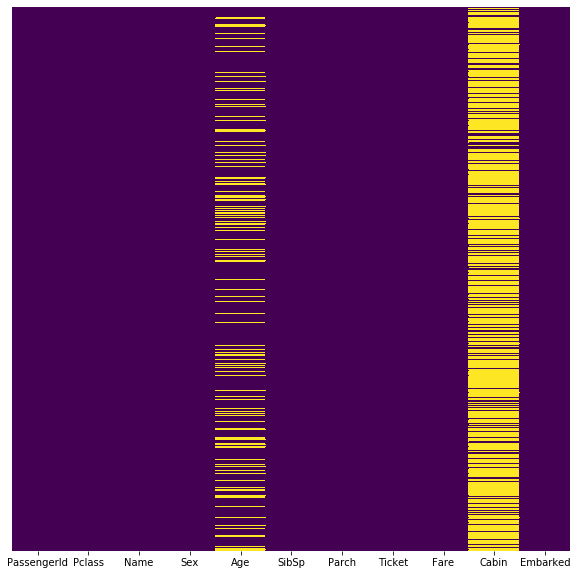

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(),cmap="viridis",yticklabels=False,cbar=False)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Step 1: Data Cleaning
* Before I explore the data with some visualisations, I'll clean up the dataset, dealing with typos and dropping redundant variables.

In [7]:
train['PassengerId'].value_counts()

891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64

In [8]:
train['Name'].value_counts()

Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)     1
Scanlan, Mr. James                                      1
Van Impe, Mrs. Jean Baptiste (Rosalie Paula Govaert)    1
Coelho, Mr. Domingos Fernandeo                          1
Dick, Mrs. Albert Adrian (Vera Gillespie)               1
                                                       ..
Boulos, Miss. Nourelain                                 1
Laleff, Mr. Kristo                                      1
Fortune, Miss. Alice Elizabeth                          1
Hedman, Mr. Oskar Arvid                                 1
Strom, Miss. Telma Matilda                              1
Name: Name, Length: 891, dtype: int64

In [9]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
D              3
E101           3
              ..
B94            1
B101           1
D46            1
C50            1
E68            1
Name: Cabin, Length: 147, dtype: int64

In [10]:
train['Ticket'].value_counts()

CA. 2343    7
1601        7
347082      7
CA 2144     6
347088      6
           ..
2674        1
11765       1
28213       1
350043      1
PC 17483    1
Name: Ticket, Length: 681, dtype: int64

The above 4 categories are redundant features for my purposes:
* 'PassengerId', 'Cabin' and 'Ticket' are all arbitrary IDs that add no present insight;
* However I will keep 'PassengerId' so that I can submit results of my model at the end of notebook
* 'Name' does not tell me much that I can't derive from 'Sex' or 'Age'

I will therefore drop these 4 columns.

In [11]:
train = train.drop(['Cabin','Ticket','Name'],axis=1)
test = test.drop(['Cabin','Ticket','Name'],axis=1)

In [12]:
# rename columns to be more descriptive
train.rename(columns={"Pclass": "PClass", "Parch": "ParCh"},inplace=True)
test.rename(columns={"Pclass": "PClass", "Parch": "ParCh"},inplace=True)

# Step 2: EDA
* Before I clean the dataset and prepare it for modelling, I want to do some initial Exploratory Data Analysis to get an idea of which factors are most indicative of survival/fatality.

In [13]:
# define default figsize helper function

def set_figsize():
    '''
    Sets default figsize to 12x8
    '''
    plt.figure(figsize=[12,8])

In [14]:
# define default legend helper function

def legend_survived():
    '''
    Plots legend with Not survived & Survived
    '''
    plt.legend(['Did not survive','Survived'],loc='best')

In [15]:
# create subsets of survived vs not_survived for hue in plots

survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

## Discrete Variables
Let's start with some plots for discrete variables (categorical variables)

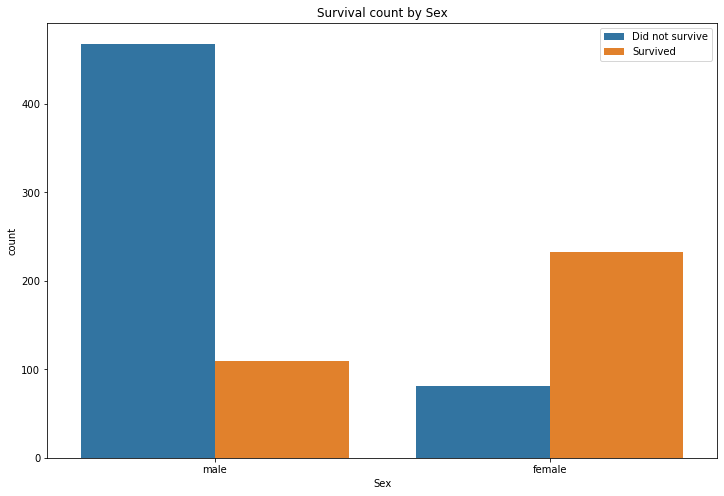

In [16]:
set_figsize()
plt.title('Survival count by Sex')
sns.countplot('Sex',data=train,hue='Survived')
legend_survived()

It is evident that male passengers are far less likely to survive than females.

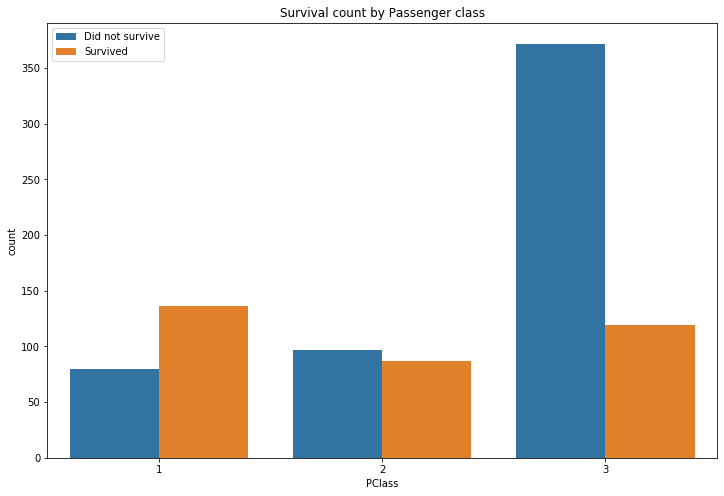

In [17]:
set_figsize()
plt.title('Survival count by Passenger class')
sns.countplot('PClass',data=train,hue='Survived')
legend_survived()

As we can see, passengers in 1st class are most likely to survive. Passengers in 3rd class are by far least likely to survive.

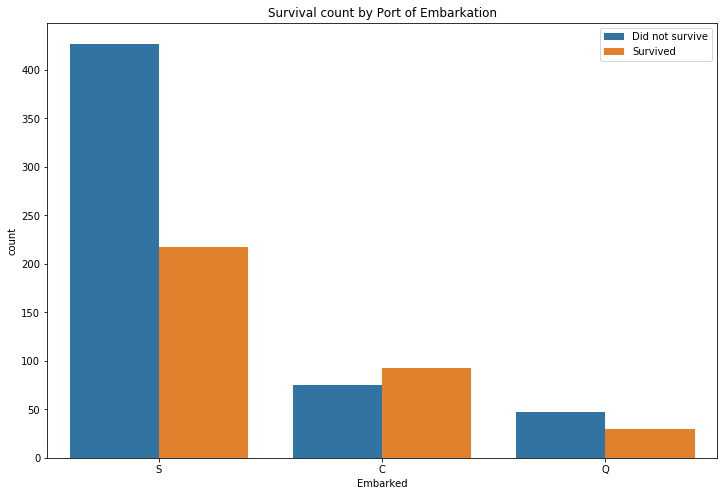

In [18]:
set_figsize()
plt.title('Survival count by Port of Embarkation')
sns.countplot('Embarked',data=train,hue='Survived')
legend_survived()

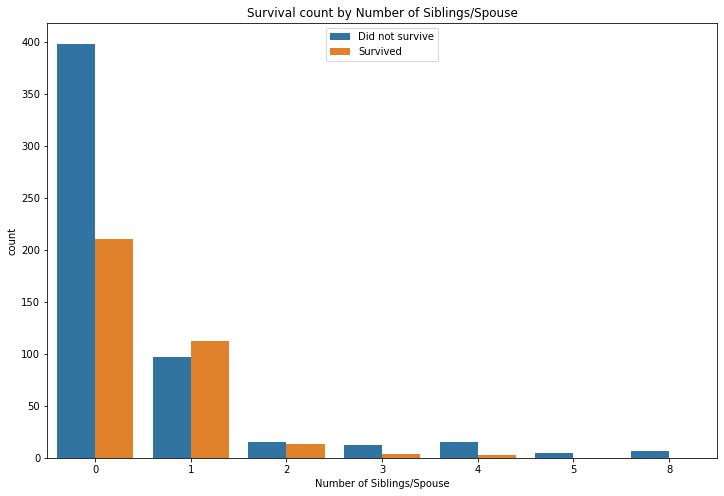

In [19]:
set_figsize()
plt.title('Survival count by Number of Siblings/Spouse')
sns.countplot('SibSp',data=train,hue='Survived')
plt.xlabel('Number of Siblings/Spouse')
legend_survived()

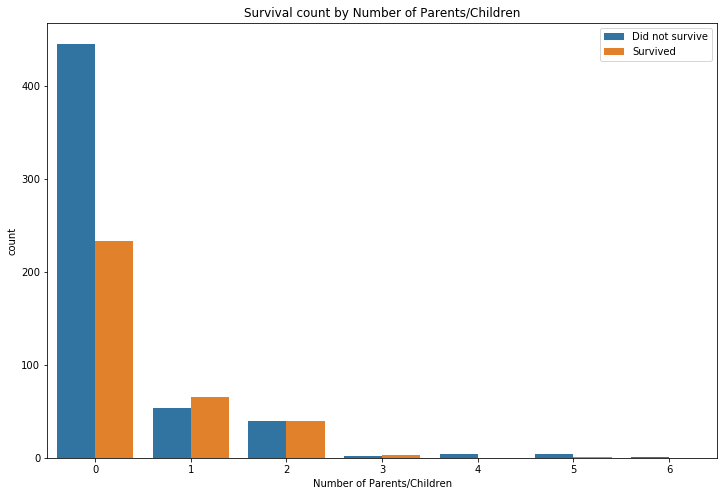

In [20]:
set_figsize()
plt.title('Survival count by Number of Parents/Children')
sns.countplot('ParCh',data=train,hue='Survived')
plt.xlabel('Number of Parents/Children')
plt.legend(['Did not survive','Survived'],loc='upper right')

## Continuous Variables
Now I will plot the remaining continuous variables ('Age' is not technically continuous, but can be treated as such for plots)

Text(0, 0.5, 'Density')

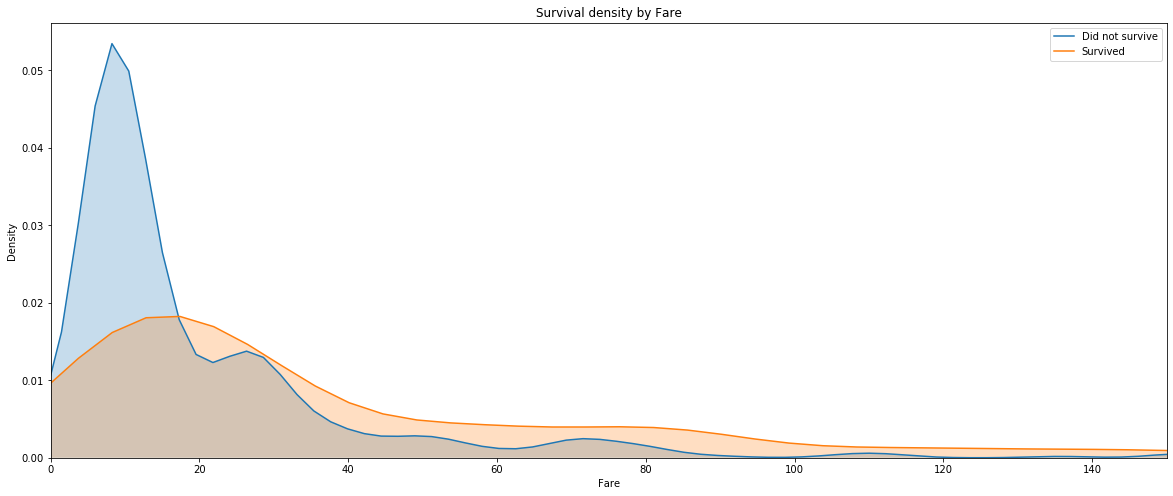

In [21]:
plt.figure(figsize=(20,8))

ax1 = sns.kdeplot(not_survived['Fare'],shade=True)
ax1.set_xlim((0,150))

ax2 = sns.kdeplot(survived['Fare'],shade=True)
ax2.set_xlim((0,150))

legend_survived()
plt.title('Survival density by Fare')
plt.xlabel('Fare')
plt.ylabel('Density')

On the whole, we see that passengers who paid a higher fare are more likely to have survived.

Text(0, 0.5, 'Density')

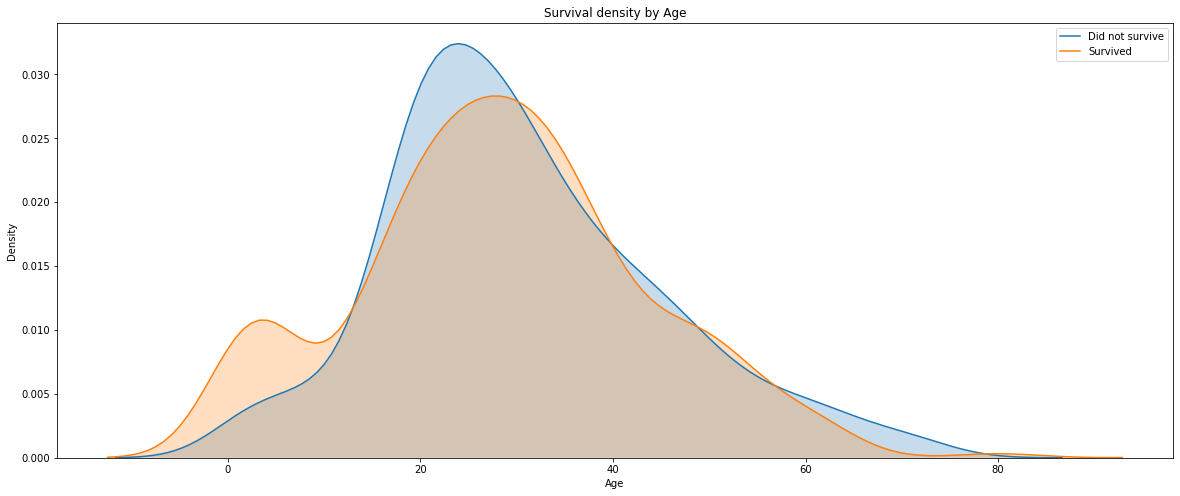

In [22]:
plt.figure(figsize=(20,8))

ax1 = sns.kdeplot(not_survived['Age'],shade=True)

ax2 = sns.kdeplot(survived['Age'],shade=True)

legend_survived()
plt.title('Survival density by Age')
plt.xlabel('Age')
plt.ylabel('Density')

### Insights on Age
Surprisingly, Age does not seem to contribute very much to survival.

The main conclusion is that passengers in their early 20s are least likely to survive.

**The plot for 'Survived' is a bimodal distribution. This tells me that extra effort was made on board the Titanic to save the youngest passengers (between 0-5 years)**

# Step 3: Preprocessing
Now that I've cleaned the data and performed EDA, I'll prepare the data for modelling by creating dummy variables and ensuring all data is numerical.

In [23]:
# Imputing Missing Age Values: choose median due to outliers, which affect mean
train['Age'].fillna(train['Age'].median(),inplace=True)

# Imputing Missing Embarked Values
train['Embarked'].fillna(train['Embarked'].value_counts().index[0], inplace=True)

#Creating a dictionary to convert Passenger Class from 1,2,3 to 1st,2nd,3rd.
d = {1:'1st',2:'2nd',3:'3rd'}

#Mapping the column based on the dictionary
train['PClass'] = train['PClass'].map(d)

# Getting Dummies of Categorical Variables
cat_vars = train[['PClass','Sex','Embarked']]
dummies = pd.get_dummies(cat_vars,drop_first=True)

# Drop original cat_vars
train = train.drop(['PClass','Sex','Embarked'],axis=1)
# Concatenate dummies and train
train = pd.concat([train,dummies],axis=1)

# Check the clean version of the train data.
train.head()

,PassengerId,Survived,Age,SibSp,ParCh,Fare,PClass_2nd,PClass_3rd,Sex_male,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,1,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,1,1,0,1


In [24]:
# split features and label
X = train.drop(['Survived'],1)
y = train['Survived']

# Use train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
# choose GBC
# make predictions
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.1,max_depth=3)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [26]:
# evaluate performance
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[140  25]
 [ 32  71]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       165
           1       0.74      0.69      0.71       103

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



In [27]:
# Imputing Missing Age Values: choose median due to outliers, which affect mean
test['Age'].fillna(test['Age'].median(),inplace=True)

# Imputing Missing Embarked Values
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# Impute Embarked
test['Embarked'].fillna(test['Embarked'].value_counts().index[0], inplace=True)


In [28]:
#Creating a dictionary to convert Passenger Class from 1,2,3 to 1st,2nd,3rd.
d = {1:'1st',2:'2nd',3:'3rd'}

#Mapping the column based on the dictionary
test['PClass'] = test['PClass'].map(d)

# Getting Dummies of Categorical Variables
cat_vars = test[['PClass','Sex','Embarked']]
dummies = pd.get_dummies(cat_vars,drop_first=True)

# Drop original cat_vars
test = test.drop(cat_vars,axis=1)
# Concatenate dummies and train
test = pd.concat([test,dummies],axis=1)

idx = test[['PassengerId']]


In [29]:
preds = model.predict(test)
results = idx.assign(Survived=preds)
results.to_csv('GBC_submission.csv',index=False)